<a href="https://colab.research.google.com/github/FrancisDcruz/OpenFairness/blob/main/crime_fareness_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install aif360

     |████████████████████████████████| 174kB 8.5MB/s 


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
pip install scipy

In [4]:
pip install xgboost

In [5]:
from scipy import stats
from scipy.stats import boxcox
import pandas as pd 
from numpy import nan
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection

In [7]:
#from sklego.linear_model import DemographicParityClassifier
#from sklego.metrics import p_percent_score
from sklearn.model_selection import cross_val_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [8]:
from google.colab import files
files.upload() 

Saving Daily_Inmates_In_Custody.csv to Daily_Inmates_In_Custody.csv


{'Daily_Inmates_In_Custody.csv': b'INMATEID,ADMITTED_DT,DISCHARGED_DT,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SEALED,SRG_FLG,TOP_CHARGE,INFRTION\r\n20209345,2/15/2020,,MIN,Y,O,M,58,DE,N,N,117.62,N\r\n20149472,9/14/2020,,MIN,Y,B,M,30,DE,N,N,120.1,N\r\n133023,8/24/2018,,MAX,Y,B,M,42,DE,N,N,125.25,Y\r\n20029823,01/06/2019,,MAX,Y,B,M,36,DE,N,N,135.2,Y\r\n20211644,10/15/2020,,MED,N,W,M,52,DE,N,N,220.21,N\r\n122980,10/22/2020,,MED,N,B,M,37,DEP,N,N,,N\r\n20019267,3/14/2020,,MAX,Y,B,M,28,DE,N,Y,120.1,Y\r\n20009388,10/13/2020,,MAX,Y,B,M,32,DEP,N,N,160.1,N\r\n20057663,2/14/2018,,MED,N,B,M,51,DE,N,N,125.25,Y\r\n20036616,6/24/2019,,MAX,Y,B,M,39,DE,N,Y,230.34,Y\r\n20196814,7/19/2018,,MAX,N,B,M,21,DE,N,Y,125.25,Y\r\n20126766,12/06/2019,,MED,N,B,M,29,DE,N,N,130.96,Y\r\n20192843,9/27/2020,,MAX,N,W,M,36,DE,N,N,160.15,N\r\n20207687,1/25/2020,,MAX,Y,W,M,28,DE,N,Y,125.25,Y\r\n20211077,09/06/2020,,MIN,Y,O,M,28,DE,N,N,150.2,N\r\n20209165,02/01/2020,,MED,Y,A,M,25,DE,N,N,125.25,N\r\n20017335,08/0

Daily inmates in custody with attributes (custody level, mental health designation, race, gender, age, leagal status, sealed status, security risk group membership, top charge, and infraction flag)

The Bradh in the column mentions whether the inmates is under mental observation.
This model tries to predict if a particular inmate is under mental obervation or not

In [42]:
data=pd.read_csv('/content/Daily_Inmates_In_Custody.csv')

In [43]:
data.head()

,INMATEID,ADMITTED_DT,DISCHARGED_DT,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SEALED,SRG_FLG,TOP_CHARGE,INFRTION
0,20209345,2/15/2020,NaN,MIN,Y,O,M,58.0,DE,N,N,117.62,N
1,20149472,9/14/2020,NaN,MIN,Y,B,M,30.0,DE,N,N,120.10,N
2,133023,8/24/2018,NaN,MAX,Y,B,M,42.0,DE,N,N,125.25,Y
3,20029823,01/06/2019,NaN,MAX,Y,B,M,36.0,DE,N,N,135.20,Y
4,20211644,10/15/2020,NaN,MED,N,W,M,52.0,DE,N,N,220.21,N


**Feature Extraction-**


*   ADMITTED_DT can be used to extract the month and year respectively





In [44]:
data['year'] = pd.DatetimeIndex(data['ADMITTED_DT']).year
data['month'] = pd.DatetimeIndex(data['ADMITTED_DT']).month

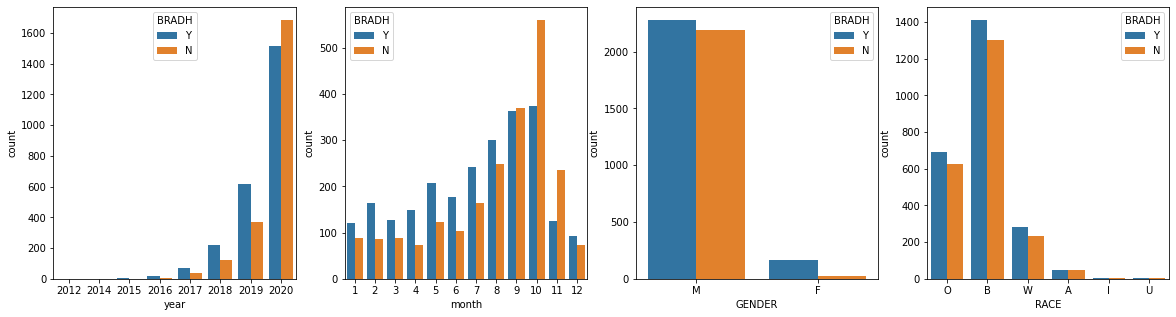

In [45]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
sns.countplot(data=data,x='year',hue='BRADH',ax=ax[0])
sns.countplot(data=data,x='month',hue='BRADH',ax=ax[1])
sns.countplot(data=data,x='GENDER',hue='BRADH',ax=ax[2])
sns.countplot(data=data,x='RACE',hue='BRADH',ax=ax[3])

The Above graph shows the distribution of mental_status(Yes/No) across Years,Months,Gender and Race 

*   We only keep the data for years from 2017



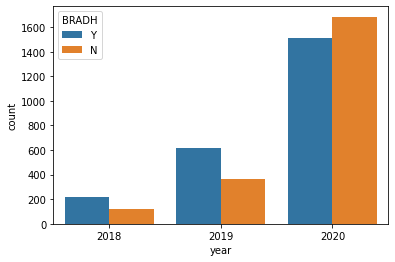

In [13]:
data=data[data['year']>2017]
sns.countplot(data=data,x='year',hue='BRADH')

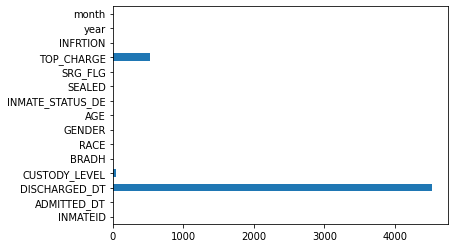

In [14]:
data.isna().sum().plot(kind='barh')

This image gives us the count of all NA(missing values) in the dataset 
1.   DISCHARGE_DT has the most number of missing values so we drop the discharged column
2.   TOP_CHARGE has a comparatively smaller number of missing values so we drop the missing rows in TOP_CHARGE(Trying to fill these missing values using mean may bring unwanted bias to the dataset)

In [15]:
data.drop(data.columns[[0,1,2]],axis=1,inplace=True)
data.drop(columns=['SEALED'],axis=1,inplace=True)
#data['TOP_CHARGE'] = pd.to_numeric(data['TOP_CHARGE'], downcast="float")
#data['TOP_CHARGE'].fillna(value=data['TOP_CHARGE'].mean(), inplace=True)
data=data.dropna()
data.head()

,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SRG_FLG,TOP_CHARGE,INFRTION,year,month
0,MIN,Y,O,M,58.0,DE,N,117.62,N,2020,2
1,MIN,Y,B,M,30.0,DE,N,120.10,N,2020,9
2,MAX,Y,B,M,42.0,DE,N,125.25,Y,2018,8
3,MAX,Y,B,M,36.0,DE,N,135.20,Y,2019,1
4,MED,N,W,M,52.0,DE,N,220.21,N,2020,10


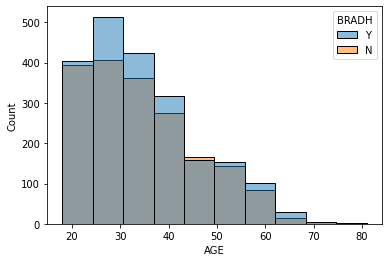

In [16]:
sns.histplot(data,bins=10,x='AGE',hue='BRADH')

In [17]:
data['zscore']= stats.zscore(data['TOP_CHARGE'])
df_new = data[(data.zscore>-3) & (data.zscore<3)]
data=df_new

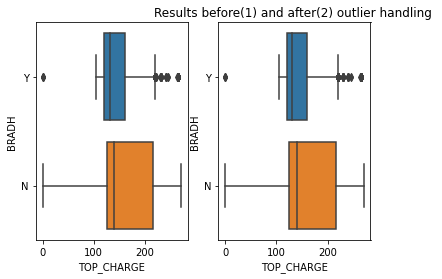

In [18]:
fig,ax=plt.subplots(1,2)
plt.title('Results before(1) and after(2) outlier handling ')
sns.boxplot(data=data,x='TOP_CHARGE',y='BRADH',ax=ax[0])
sns.boxplot(data=df_new,x='TOP_CHARGE',y='BRADH',ax=ax[1])
data=df_new

In [20]:
data=data[data['TOP_CHARGE']!=0]
data['TOP_CHARGE'] = boxcox(data['TOP_CHARGE'],0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
data=data.drop(columns=['zscore'])
cols=data.select_dtypes(include='object').columns.drop('GENDER','BRADH')
data=pd.get_dummies(data,columns=cols)
data=data.drop(columns='BRADH_N')
df1 = data.pop('BRADH_Y') # remove column b and store it in df1
data['mental_status']=df1 # add b series as a 'new' column.
data['GENDER'] = data['GENDER'].astype('category')
data['GENDER'] = data['GENDER'].cat.codes
cols=data.columns

In [23]:
x = data[data.columns[data.columns != 'mental_status']]
y = data.mental_status

The below step we are checking the p_values of all variables for feature elimination

In [24]:
regressor_OLS = sm.OLS(y,x).fit()
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:          mental_status   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     17.95
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           1.27e-63
Time:                        03:38:42   Log-Likelihood:                -2636.4
No. Observations:                3896   AIC:                             5317.
Df Residuals:                    3874   BIC:                             5455.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
GENDER                  -0.3850 

In [25]:
def GetModelResult(X,Y):
  ratio=float(np.sum(Y==0)) / np.sum(Y==1)
  cols = ['Model', 'Accuracy', 'Precision','Recall']  
  Model_Result=pd.DataFrame(columns = cols) 
  models=[]
  models.append(('LR', LogisticRegression(random_state=0,max_iter=1000,C=0.01,penalty='l2')))
  models.append(('LDA', LinearDiscriminantAnalysis()))
  models.append(('KNN', KNeighborsClassifier(n_neighbors = 19, metric = 'minkowski', p = 1,leaf_size=3)))
  models.append(('CART', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
  models.append(('NB', GaussianNB()))
  models.append(('SVM', SVC(kernel='linear', random_state= 0)))
  models.append(('RF',RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)))
  models.append(('XGB', XGBClassifier(scale_pos_weight=ratio)))
  # evaluate each model in turn
   
  scoring = ['accuracy','precision','recall']
  for name, model in models:
    df_result=[]
    results = []
    kfold = model_selection.KFold(n_splits=10)
    results.append(name)
    for score in scoring:
      cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=score)
      #print("%s: %f (%f)" % (score, cv_results.mean(), cv_results.std()))
      results.append(cv_results.mean())
    zipped=zip(cols,results)  
    df_result.append(dict(zipped))
    Model_Result=Model_Result.append(df_result,True)
  print(Model_Result)
  #Visualizing the results:
  fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
  fig.suptitle('Algorithm Comparison')
  print()
  custom_ylim = (0,1)
  Model_Result.plot(kind='bar',x='Model',y='Accuracy',ax=ax[0],ylim=custom_ylim)
  Model_Result.plot(kind='bar',x='Model',y='Precision',ax=ax[1],ylim=custom_ylim)
  Model_Result.plot(kind='bar',x='Model',y='Recall',ax=ax[2],ylim=custom_ylim)
  

def score(y_test,y_pred):
  print(pd.crosstab(
    pd.Series(y_test,name='Actual'),
    pd.Series(y_pred,name='Predicted'),
    margins=True
  ))
  print('Accuracy:{0:.2f}'.format(accuracy_score(y_test,y_pred)))
  print('Precision:{0:.2f}'.format(precision_score(y_test,y_pred)))
  print('Recall:{0:.2f}'.format(recall_score(y_test,y_pred)))

def ROC(model,y_test,probs):
  fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])
  plt.title('ROC CURVE')
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.plot(fpr, tpr)
  plt.show()
  
  

def cvscore(model,x_train,y_train):
  scores = cross_val_score(model, x_train, y_train, cv=5)
  print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [26]:
fair_data=data
pred_data=data.drop(columns='mental_status',axis=1)#dataset created for fairness classificationMetric
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.30,random_state=0)

In [28]:
train=np.concatenate((x_train,y_train.reshape(-1,1)),axis=1)
test=np.concatenate((x_test,y_test.reshape(-1,1)),axis=1)
train=pd.DataFrame(train,columns=cols)
test=pd.DataFrame(test,columns=cols)

Data Creation for Fairness Metrics 

In [29]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

  Model  Accuracy  Precision    Recall
0    LR  0.620140   0.634619  0.713066
1   LDA  0.607683   0.633587  0.651218
2   KNN  0.599234   0.618524  0.686765
3  CART  0.570608   0.604755  0.601901
4    NB  0.493230   0.833696  0.107561
5   SVM  0.613172   0.635165  0.677603
6    RF  0.579037   0.616554  0.593417
7   XGB  0.628193   0.656017  0.668221



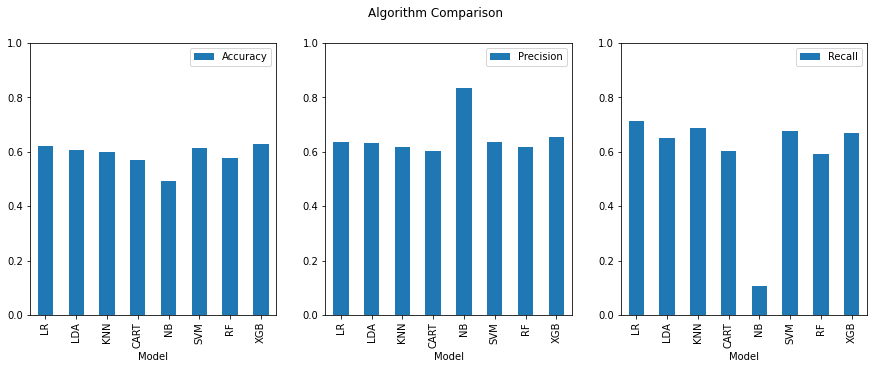

In [30]:
GetModelResult(x_train,y_train)

Naive Bayes has the best precision but since it has the lowest accuracy and recall we do not go with Naive Bayes
Since we notice that XGBBoost Model has the  best accuray and precision we go with XGBBoost as the model to test our fairness matix

# **Predictions before performing fairness transformation**


Predicted    0    1   All
Actual                   
0          303  258   561
1          189  419   608
All        492  677  1169
Accuracy:0.62
Precision:0.62
Recall:0.69


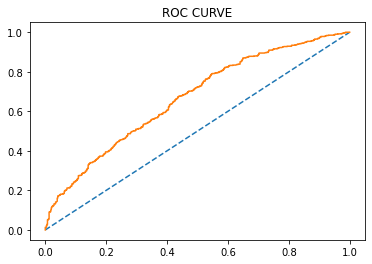

In [31]:
ratio=float(np.sum(y_train==0)) / np.sum(y_train==1)#ratio between the number of 0 and 1 to handle imablanced  in the datasets
model=XGBClassifier(scale_pos_weight=ratio).fit(x_train,y_train)
y_pred=model.predict(x_test)
fair_pred=model.predict(x_train)
probs = model.predict_proba(x_test)
score(y_test,y_pred)
ROC(model,y_test,probs)

The above graph is showing the performance of a classification model at all classification thresholds.

# Fairness Model Implementation 

In [32]:
fair_data=train
x=train.iloc[:,:-1].values
pred_data=np.concatenate((x,fair_pred.reshape(-1,1)),axis=1)
pred_data=pd.DataFrame(pred_data,columns=cols)

Since 0 is not in mental status so 0 is our favorable label and since male is 1 so 1 is our privileged group 

In [33]:
train_pp_bld = BinaryLabelDataset(df=fair_data,
                                  label_names=['mental_status'],
                                  protected_attribute_names=['GENDER'],
                                  favorable_label=0,
                                  unfavorable_label=1)
pred_pp_bld = BinaryLabelDataset(df=pred_data,
                                  label_names=['mental_status'],
                                  protected_attribute_names=['GENDER'],
                                  favorable_label=0,
                                  unfavorable_label=1)

privileged_groups = [{'GENDER': 0,}] 
unprivileged_groups = [{'GENDER': 1}]

For this time we consider GENDER as the sensitive feature with 1 being the privileged group and 0 being the unprivileged group

In [34]:
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

In [35]:
class_train_bld = ClassificationMetric(train_pp_bld,pred_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

In [36]:
explainer = MetricTextExplainer(metric_train_bld)
explainer.statistical_parity_difference()
#print(explainer.disparate_impact())

'Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.4040182435581597'

In [37]:
explainer = MetricTextExplainer(class_train_bld)
print(explainer.statistical_parity_difference())
print(explainer.average_odds_difference())
print(explainer.equal_opportunity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.4431753112723883
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): 0.34454332328948334
True positive rate difference (true positive rate on unprivileged instances - true positive rate on privileged instances): 0.3894502829426031


In [38]:
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
rw_data = rw.fit_transform(train_pp_bld)

In [39]:
metric_train_bld = BinaryLabelDatasetMetric(rw_data,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

In [40]:
explainer = MetricTextExplainer(metric_train_bld)
explainer.statistical_parity_difference()

'Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -5.551115123125783e-17'